### BUFN400---University of Maryland

# Homework 2: Bonds and Mortgages: Theoretical Calculations

### By Albert S. (Pete) Kyle

There are probably some typos or errors in this homework.  If you find something which seems wrong, please let me know!

$\renewcommand{\E}{\mathrm{E}}$
$\renewcommand{\e}{\mathrm{e}}$
$\renewcommand{\drm}{\mathrm{\, d}}$
$\renewcommand{\var}{\mathrm{var}}$
$\renewcommand{\cov}{\mathrm{cov}}$
$\renewcommand{\stdev}{\mathrm{stdev}}$
$\renewcommand{\sm}{ {\scriptstyle{*}} }$
$\renewcommand{\mm}{{\scriptsize @}}$
$\renewcommand{\t}{^{\mathsf{T}}}$
$\renewcommand{\comma}{\, , \,}$
$\renewcommand{\vec}[1]{\mathbf{#1}}$


In [90]:
import pandas as pd
import numpy as np
import scipy
#import scipy.sparse.linalg
import matplotlib
import matplotlib.pyplot as plt

import sys
import io
import datetime
import numba
import timeit

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 100)
#pd.set_option("display.precision", 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('NumPy version ' + np.__version__)
print('SciPy version ' + scipy.__version__)
print('matplotlib version ' + matplotlib.__version__)

timestamp = datetime.datetime.now().strftime('%Y-%m%d-%H%M')
print("Timestamp:", timestamp)
tstart = timeit.default_timer()

Python version 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
Pandas version 1.5.3
NumPy version 1.24.3
SciPy version 1.10.1
matplotlib version 3.7.1
Timestamp: 2023-0927-1350


### Exercise 1

The purpose of this exercise is to make sure you understand how cash flows on different types of bonds differ from one another. In fixed income markets, different types of bonds are issued by different types of issuers.

* The U.S. government tends to issue coupon bonds which pay semi-annual interest and pay back the entire face value at maturity. This type of bond has **no amortization of principal**.

* Individual homeowners often borrow with 30-year, fixed rate mortgages whose monthly payments are constant (like annuities) and pay back the amount of the loan gradually, so that the entire loan is fully repaid with the last (360th) monthly payment.  This type of bond has **full amortization of principal** over the life of the loan. If paid back before maturity, the is a principal balance outstanding which must be prepaid.  At maturity, the principal balance is zero after the final (360th) payment.

* Commercial real estate borrowers often borrow with maturities shorter than 30 years (say 10 years). Monthly payments correspond to those on a longer maturity mortgage (say 30 years). At the maturity date, there is a principal balance outstanding which must be paid (**baloon payment**) because the amortization schedule (based on say a 30-year mortgage) does not pay back the entire principal amount at maturity.  This type of bond has **partial amortization of principal** over the life of the loan.

1. Write function which takes inputs and produces outputs described by the doc-string in the next cell. This function should cover all three types of amortization schedules mentioned above.

2. Display the first 5 lines and last 5 lines of dataframes returned for three cases, each of which has face value of 100,000 and coupon of 6 percent of face value. The three cases are:

* U.S Treasury security: maturity of 10 years, no amortization of principal.

* Residential mortgage: maturity = 30 years, amortization_horizon = 30 years.

* Commercial real estate: maturity = 10 years, amortization_horizon = 30 years. (Hint for debugging: My calculations indicate amount owed after last payment is about 83685 dollars. If you think my answer is incorrect, please let me know. Your answer should show both dollars and cents.)

2. In one sentence, explain why this function depends on the coupon rate but does not depend on the yield to maturity.

The yield to maturity is the internal rate of return of the investment, but the return of the investment has no impact on the contractual details of the loan (ie. when you will pay back all of the principal). On the other hand, the coupon rate is directly used in computing the monthly payments in the case of full or amortized princpal investments, so this function does depend on the coupon rate.

Hints:

A. It is hard to write this function without using a Python loop, so a Python loop is okay in this case.

B. When principal is amortized, you probably want to use an annuity formula (see lecture notes) to determine the monthly payment.

C. For nice display, you might use `pd.set_option('display.float_format', lambda x: '%.2f' % x)` to display results to cents. This option is already set in the cell above which loads packages.


In [91]:
def f_balance(loan_amount, coupon_rate, maturity, amortization_horizon=None, num_per_year=12):
    """
    Sample inputs:
    loan_amount = 400000 dollars (typical amount borrowed to buy 500000 dollar home)
    coupon_rate = 0.06 for 6 percent annual rate
    maturity = 30 years for typical mortgage, 10 years for commercial real estate mortgage
    amortization_horizon = 30 years (same as maturity for typical mortgage), None means interest only
    num_per_year = 12 for monthly payments (= 2 for semi-annual payments)

    Outputs: pd.DataFrame with the following columns for each period (e.g., month):
    'prebalance' = amount owed before payment is made (post_balance from last month plus interest)
    'payment' = payment on loan (zero in first month, constant for remaining months)
    'interest' = dollar portion of payment which is interest on loan
    'principal' = dollar protion of payment which pays down loan balance
    'post_balance' = amount in addition to 'payment' needed to pay off loan early or at maturity (last row),

    Notes:
    The number of rows in the Panda's dataframe is 'num_per_year' x 'maturity' + 1.
    In row 0, the 'pre_balance' and 'post_balance' both equal the loan_amount, and no payment made.
    In the last row, the 'post_balance' is the extra amount needed to pay off the loan.
    In each row, the sum of 'interest' and 'principal' should equal 'payment'.
    The 'post_balance' decreases monotonically over time.
    If maturity = amortization_horizon, then 'post_balance' in last row is zero (up to rounding error)
    If amortization_horizon is None, then loan is "interest only". This means
            'post_balance' is a constant equal to loan_amount in every row,
            'pre_balance' is 'loan_amount' plus one-month's interest in every row except row 0,
            'payment' and 'interest' are the same constant in every row,
            and 'principal' is zero (because loan balance is not reduced).
    """
    # Intialize numpy arrays that we will append to as we iterate throgh the periods
    prebalance = np.array([loan_amount])
    payment = np.array([0])
    interest = np.array([0])
    principal = np.array([0])
    postbalance = np.array([loan_amount])

    # Define a few other assumption variables
    total_periods = num_per_year * maturity + 1
    yN = coupon_rate / num_per_year
    if amortization_horizon:
        cannual = loan_amount * coupon_rate / (1.00 - 1.00 / (1.00 + coupon_rate / num_per_year) ** (amortization_horizon * num_per_year))

    # Iterate through the periods
    for _ in range(1, total_periods):

        # If amortization of principal is None, then the loan is interest only
        if not amortization_horizon:
            prebalance_amount = loan_amount * (1 + yN)
            postbalance_amount = loan_amount
            interest_amount = prebalance_amount - postbalance_amount
            payment_amount = interest_amount
            principal_amount = 0

        # If full amortization of loans or partial amortization of loans
        else:
            # Calculate amounts for this period
            prebalance_amount = postbalance[-1] * (1 + yN)
            interest_amount = prebalance_amount - postbalance[-1]
            payment_amount = cannual / 12.0
            principal_amount = payment_amount - interest_amount
            postbalance_amount = prebalance_amount - payment_amount

        # Append values to our numpy arrays
        prebalance = np.append(prebalance, prebalance_amount)
        interest = np.append(interest, interest_amount)
        payment = np.append(payment, payment_amount)
        principal = np.append(principal, principal_amount)
        postbalance = np.append(postbalance, postbalance_amount)

    return pd.DataFrame({
        "prebalance": prebalance,
        "payment": payment,
        "interest": interest,
        "principal": principal,
        "postbalance": postbalance
    })

In [92]:
# Case 1: US Treasury Security with No Amortization of Principal
print("Case 1: US Treasury Security with No Amortization of Principal")
df_one = f_balance(100000, 0.06, 10, None, 2)
display(df_one.head(), df_one.tail())

# Case 2: Residental Mortgage with Full Amortization
print("Case 2: Residential Mortage with Full Amortiztion of Principal")
df_two = f_balance(100000, 0.06, 30, 30, 12)
display(df_two.head(), df_two.tail())

# Case 3: Commercial real estate with Partial Amortization
print("Case 3: Commercial real estate with Partial Amortization of Principal")
df_three = f_balance(100000, 0.06, 10, 30, 12)
display(df_three.head(), df_three.tail())

Case 1: US Treasury Security with No Amortization of Principal


,prebalance,payment,interest,principal,postbalance
0,100000.00,0.00,0.00,0,100000
1,103000.00,3000.00,3000.00,0,100000
2,103000.00,3000.00,3000.00,0,100000
3,103000.00,3000.00,3000.00,0,100000
4,103000.00,3000.00,3000.00,0,100000


,prebalance,payment,interest,principal,postbalance
16,103000.00,3000.00,3000.00,0,100000
17,103000.00,3000.00,3000.00,0,100000
18,103000.00,3000.00,3000.00,0,100000
19,103000.00,3000.00,3000.00,0,100000
20,103000.00,3000.00,3000.00,0,100000


Case 2: Residential Mortage with Full Amortiztion of Principal


,prebalance,payment,interest,principal,postbalance
0,100000.00,0.00,0.00,0.00,100000.00
1,100500.00,599.55,500.00,99.55,99900.45
2,100399.95,599.55,499.50,100.05,99800.40
3,100299.40,599.55,499.00,100.55,99699.85
4,100198.35,599.55,498.50,101.05,99598.80


,prebalance,payment,interest,principal,postbalance
356,2968.07,599.55,14.77,584.78,2368.52
357,2380.36,599.55,11.84,587.71,1780.81
358,1789.72,599.55,8.90,590.65,1190.17
359,1196.12,599.55,5.95,593.60,596.57
360,599.55,599.55,2.98,596.57,-0.00


Case 3: Commercial real estate with Partial Amortization of Principal


,prebalance,payment,interest,principal,postbalance
0,100000.00,0.00,0.00,0.00,100000.00
1,100500.00,599.55,500.00,99.55,99900.45
2,100399.95,599.55,499.50,100.05,99800.40
3,100299.40,599.55,499.00,100.55,99699.85
4,100198.35,599.55,498.50,101.05,99598.80


,prebalance,payment,interest,principal,postbalance
116,85000.80,599.55,422.89,176.66,84401.25
117,84823.25,599.55,422.01,177.54,84223.70
118,84644.82,599.55,421.12,178.43,84045.27
119,84465.50,599.55,420.23,179.32,83865.95
120,84285.28,599.55,419.33,180.22,83685.72


### Exercise 1 (continued). Extra credit problem

3. Extra credit: Try to make the function `f_balance` numerically efficient by using the Python package Numba to make loops faster. For example, use what appears to be a dumb Python loop over a Numpy array, but speed it up with the Numba decorator `@numba.njit(...)` and the use of `numba.prange` instead of Python's `range`. Since Numba may not recognize Panda's dataframes, modify the function `f_balance` so that the function `f_balance` calls another function which is compiled with Numba and returns a tuple of numpy arrays.

    * Hint: To get this to work without taking a deep dive into the Numba documentation, you should write the Numba function in a seemingly dumb, simplistic manner which makes it easy for Numba's **just-in-time** (**jit**) compiler to infer the types of arguments to the functions. Numba recognizes Numpy arrays but does not recognize some other data types.  To get you started, here is an example using Numba to calculate an inner product. When a Numba-compiled function is called for the first time, the jit compiler takes some time to compile the function.  Therefore, it is a good idea to call the function once before timing it, so tht compile time is not part of the function timing.

Numba functions are implemented below.

4. By what factor does the use of Numba decrease execution time?

In the `f_balance` example that I did, it decreaases execution time by about a factor of 8.

5. In two sentences, provide an intuitive explanation for the different timings of `np.dot`, `f_inner_product_fast`, and `f_inner_product_slow` in the sample code below.

Numpy is written in C and Fortran and then the result is converted back to Python, which is greatly faster than running everything in Python which is an interpreted language whereas the other two are compiled languages. This is why `f_inner_product_slow` is so slow and `np.dot` is signifigantly faster. `f_inner_product_fast` is also faster because Numba compiles Python code and generates optimized machine code,

6. In one sentence, provide an intuitive explanation for speedups you see in your Numba function.

An intuitive speedup in the numba function is the loops can easily be translated into machine code. It does not recognize Pandas dataframes for example because it cannot convert that to machine code.

In [93]:
# EXTRA CREDIT
def f_balance_brute_force(loan_amount, coupon_rate, maturity, amortization_horizon=-1, num_per_year=12):
    # Intialize numpy arrays that we will append to as we iterate throgh the periods
    prebalance = [loan_amount]
    payment = [0]
    interest = [0]
    principal = [0]
    postbalance = [loan_amount]
    # Define a few other assumption variables
    total_periods = num_per_year * maturity + 1
    yN = coupon_rate / num_per_year
    if amortization_horizon:
        cannual = loan_amount * coupon_rate / (1.00 - 1.00 / (1.00 + coupon_rate / num_per_year) ** (amortization_horizon * num_per_year))

    # Iterate through the periods
    for _ in numba.prange(1, total_periods):

        # If amortization of principal is None, then the loan is interest only
        if amortization_horizon == -1:
            prebalance_amount = loan_amount * (1 + yN)
            postbalance_amount = loan_amount
            interest_amount = prebalance_amount - postbalance_amount
            payment_amount = interest_amount
            principal_amount = 0

        # If full amortization of loans or partial amortization of loans
        else:
            # Calculate amounts for this period
            prebalance_amount = postbalance[-1] * (1 + yN)
            interest_amount = prebalance_amount - postbalance[-1]
            payment_amount = cannual / 12.0
            principal_amount = payment_amount - interest_amount
            postbalance_amount = prebalance_amount - payment_amount

        # Append values to our numpy arrays
        prebalance.append(prebalance_amount)
        interest.append(interest_amount)
        payment.append(payment_amount)
        principal.append(principal_amount)
        postbalance.append(postbalance_amount)

    return helper_brute_force(prebalance, interest, payment, principal, postbalance)

def helper_brute_force(prebalance, interest, payment, principal, postbalance):
    return np.array(list(zip(prebalance, interest, payment, principal, postbalance)))

@numba.jit()
def f_balance_using_numba(loan_amount, coupon_rate, maturity, amortization_horizon=-1, num_per_year=12):
    # Intialize numpy arrays that we will append to as we iterate throgh the periods
    prebalance = [loan_amount]
    payment = [0]
    interest = [0]
    principal = [0]
    postbalance = [loan_amount]
    # Define a few other assumption variables
    total_periods = num_per_year * maturity + 1
    yN = coupon_rate / num_per_year
    if amortization_horizon:
        cannual = loan_amount * coupon_rate / (1.00 - 1.00 / (1.00 + coupon_rate / num_per_year) ** (amortization_horizon * num_per_year))

    # Iterate through the periods
    for _ in numba.prange(1, total_periods):

        # If amortization of principal is None, then the loan is interest only
        if amortization_horizon == -1:
            prebalance_amount = loan_amount * (1 + yN)
            postbalance_amount = loan_amount
            interest_amount = prebalance_amount - postbalance_amount
            payment_amount = interest_amount
            principal_amount = 0

        # If full amortization of loans or partial amortization of loans
        else:
            # Calculate amounts for this period
            prebalance_amount = postbalance[-1] * (1 + yN)
            interest_amount = prebalance_amount - postbalance[-1]
            payment_amount = cannual / 12.0
            principal_amount = payment_amount - interest_amount
            postbalance_amount = prebalance_amount - payment_amount

        # Append values to our numpy arrays
        prebalance.append(prebalance_amount)
        interest.append(interest_amount)
        payment.append(payment_amount)
        principal.append(principal_amount)
        postbalance.append(postbalance_amount)

    return helper_using_numba(prebalance, interest, payment, principal, postbalance)

@numba.njit()
def helper_using_numba(prebalance, interest, payment, principal, postbalance):
    return np.array(list(zip(prebalance, interest, payment, principal, postbalance)))


C:\Users\Guest User\AppData\Local\Temp\ipykernel_12344\2629138626.py:47: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [94]:
res1 = f_balance_brute_force(100000, 0.06, 10, 30, 12)
res2 = f_balance_using_numba(100000, 0.06, 10, 30, 12)
print(f"Should be the same: {res1=}, {res2=}\n")
# Time the three different functions to see which is fastest:

for _ in range(3):
    print("F balance brute force: ", end="")
    %timeit -r 5 -n 21 res = f_balance_brute_force(100000, 0.06, 10, 30, 12)
    print("F balance using numba: ", end="")
    %timeit -r 5 -n 21 res = f_balance_using_numba(100000, 0.06, 10, 30, 12)
    print("")

Should be the same: res1=array([[1.00000000e+05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+05],
       [1.00500000e+05, 5.00000000e+02, 5.99550525e+02, 9.95505252e+01,
        9.99004495e+04],
       [1.00399952e+05, 4.99502247e+02, 5.99550525e+02, 1.00048278e+02,
        9.98004012e+04],
       [1.00299403e+05, 4.99002006e+02, 5.99550525e+02, 1.00548519e+02,
        9.96998527e+04],
       [1.00198352e+05, 4.98499263e+02, 5.99550525e+02, 1.01051262e+02,
        9.95988014e+04],
       [1.00096795e+05, 4.97994007e+02, 5.99550525e+02, 1.01556518e+02,
        9.94972449e+04],
       [9.99947311e+04, 4.97486224e+02, 5.99550525e+02, 1.02064301e+02,
        9.93951806e+04],
       [9.98921565e+04, 4.96975903e+02, 5.99550525e+02, 1.02574622e+02,
        9.92926060e+04],
       [9.97890690e+04, 4.96463030e+02, 5.99550525e+02, 1.03087495e+02,
        9.91895185e+04],
       [9.96854661e+04, 4.95947592e+02, 5.99550525e+02, 1.03602933e+02,
        9.90859155e+04],
     

In [95]:
def f_inner_product_slow(x, y):
    assert x.shape == y.shape
    assert x.ndim == 1
    res = 0.00
    for n in range(len(x)):
        res = res + x[n] * y[n]
    return res

# @numba.njit(parallel=True, fastmath=True)
@numba.njit()
def f_inner_product_fast(x, y):
    assert x.shape == y.shape
    assert x.ndim == 1
    res = 0.00
    for n in numba.prange(len(x)):
        res = res + x[n] * y[n]
    return res

# Test inner product on random vectors of length N:

N = 10**6

rng = np.random.default_rng(seed=1234)
x = rng.normal(loc=1.00, scale=5.00, size=N)
y = rng.normal(loc=0.00, scale=1.00, size=N)

res00 = np.dot(x, y)
res0 = x @ y
res1 = f_inner_product_slow(x, y)
res2 = f_inner_product_fast(x, y)

print(f"Should be the same: {res00=}, {res0=}, {res1=}, {res2=}\n")

# Time the three different functions to see which is fastest:

for _ in range(3):
    print("np.dot: ", end="")
    %timeit -r 5 -n 21 res = np.dot(x, y)
    print("f_inner_product_fast: ", end="")
    %timeit -r 5 -n 11 res = f_inner_product_fast(x, y)
    print("f_inner_product_slow: ", end="")
    %timeit -r 3 -n 1 res = f_inner_product_slow(x, y)
    print("")

Should be the same: res00=-5999.95682442272, res0=-5999.95682442272, res1=-5999.956824422779, res2=-5999.956824422779

np.dot: 318 µs ± 23.4 µs per loop (mean ± std. dev. of 5 runs, 21 loops each)
f_inner_product_fast: 1.43 ms ± 147 µs per loop (mean ± std. dev. of 5 runs, 11 loops each)
f_inner_product_slow: 317 ms ± 46.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)

np.dot: 300 µs ± 27.8 µs per loop (mean ± std. dev. of 5 runs, 21 loops each)
f_inner_product_fast: 1.45 ms ± 112 µs per loop (mean ± std. dev. of 5 runs, 11 loops each)
f_inner_product_slow: 324 ms ± 19.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)

np.dot: 304 µs ± 46.6 µs per loop (mean ± std. dev. of 5 runs, 21 loops each)
f_inner_product_fast: 1.3 ms ± 59.3 µs per loop (mean ± std. dev. of 5 runs, 11 loops each)
f_inner_product_slow: 318 ms ± 38.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)



### Exercise 2

In the lecture note on Time Value of Money, there was a specific yield-curve function with three parameters (long rate, short rate, "mean reversion" parameter).  Use this function (with the same parameters) for this exercise. The function is copied to the cell below.

Interpret this yield curve as based on continuously compounded interest rates.

1.  Assume (perhaps unwisely?) that this yield curve is unchanging in the sense that at every future date, an investor expects to see the same yield curve function. This creates the subjective possibility of **riding the yield curve** by investing in longer-dated securities rather than shorter dated ones.

    * For various holding periods $\Delta t$ (say one month, six months, one year, two years, five years), plot the annualized rate of return for buying a security of maturity $m$, then selling it $\Delta t$ periods of time later. Find (by numerical experimentation or otherwise) the maturity $m$ at which an investment gives the highest return. (Hint: The answer can be obtained by taking a ratio of discount factors.)

    * In one or two sentences, provide some intuition for your result to explain why the best strategy may actually avoid the longest maturity. (This may be contrary to the intuition in the class notes, which I may need to revise.)

3. Now assume that the yield curve is unchanging in the sense that any strategy of rolling over investments at various maturities will always yield the same return.  Provide a plot of the five year, two year, six month, one month, and instantaneous forward rates.

4. Extra Credit: Repeat the analysis in questions 1 and 2 assuming that the yield curve represents a rate compounded twice per year (bond-equivalent yield).

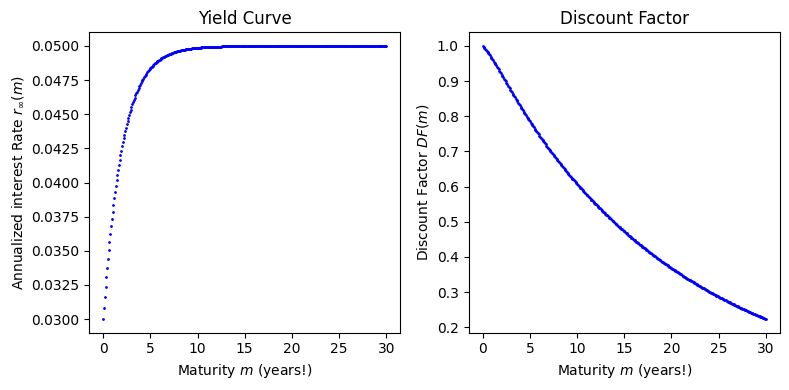

In [96]:
# This function defines the yield curve:
def fyc(m, parms):
    assert (type(parms) == np.ndarray and parms.shape == (3,)
           ), "Parameters parms should be a numpy array with three elements."
    # Parameters parms packed into numpy array for convenience in later use.
    # Unpack the parameters here so that they have intuitive names:
    rlong = parms[0]  # e.g., 0.0500
    rshort = parms[1] # e.g. 0.0300
    alpha = parms[2] #e.g. 0.50  # 1 / alpha = half-life of deviation from "long rate"

    # Now define the term structure function.
    # NB: The np.exp function here not related to continuous compounding.
    r = rlong - (rlong - rshort) * np.exp(-alpha * m)
    return r

# Construct a vector of parameters by defining the parameters a priori.
# (In a realistic application, these parameters would be estimated from data on securities prices)
rlong0 = 0.05
rshort0 = 0.03
alpha0 = 0.50
parms = np.array([rlong0, rshort0, alpha0])

# Plot the yield curve
mmax = 30.00 # years to plot on horizontal axis
nobs = 360 + 1 # The extra 1 makes the time between each observation equal to exactly one month.
m = np.linspace(start=0.00, stop=mmax, num=nobs, endpoint=True) # vector of maturities to plot
rm = fyc(m, parms) # vector of interest rates from yield curve
dfm = np.exp(-rm * m)  # continuously compounded discount factor for different maturities m

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(m, rm, 'bo', markersize=1.00)
ax[0].set_title("Yield Curve")
ax[0].set_xlabel("Maturity $m$ (years!)" )
ax[0].set_ylabel("Annualized interest Rate $r_\infty(m)$")

ax[1].set_title("Discount Factor")
ax[1].set_xlabel("Maturity $m$ (years!)")
ax[1].set_ylabel("Discount Factor $DF(m)$")
ax[1].plot(m, dfm, 'bo', markersize=1.00)

plt.tight_layout() # Prevents plots from being squashed together too much.
plt.show()


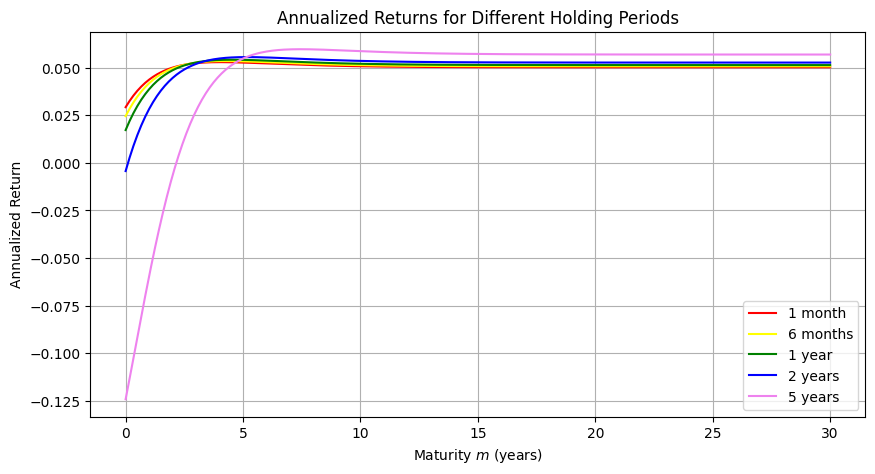

In [97]:
# Part 1. Finding the optimal maturity m that gives the highest investment return
holding_periods = [1/12, 0.5, 1, 2, 5]
colors = ['red', 'yellow', 'green', 'blue', 'violet']
labels = ['1 month', '6 months', '1 year', '2 years', '5 years']
combined = zip(holding_periods, colors, labels)

def compute_annualized_returns(m, dt, parms):
    # Compute the discount factor by holding until maturity
    df_m = np.exp(-fyc(m, parms) * m)
    # Compute the discount factor by rolling over
    df_m_dt = np.exp(-fyc(m - dt, parms) * (m - dt))
    pct_change = (df_m_dt - df_m) / df_m
    # Note that the returned value is a dimensionless quantity
    return pct_change / dt

plt.figure(figsize=(10,5))
for dt, color, label in combined:
    plt.plot(m, compute_annualized_returns(m, dt, parms), color=color, label=label)

plt.title("Annualized Returns for Different Holding Periods")
plt.xlabel("Maturity $m$ (years)")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid(True)
plt.show()

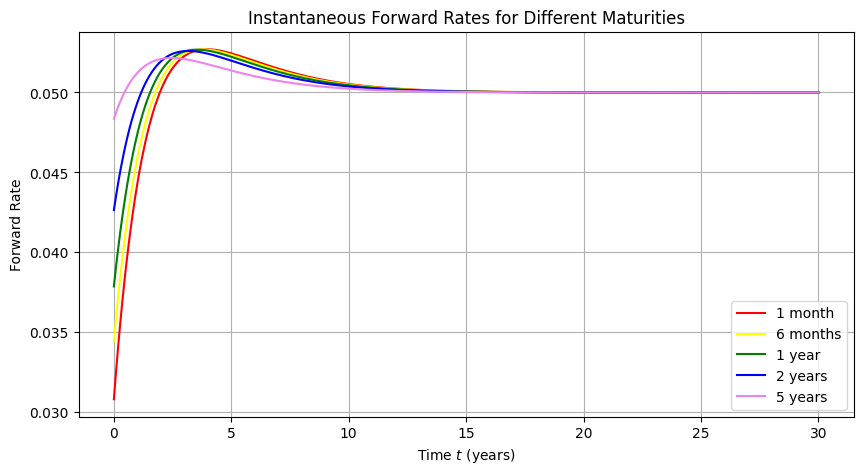

In [98]:
# Part 2. Plotting the instantaneous forward rates
def forward_rate(t, dt, parms):
    rt = fyc(t, parms)
    rt_dt = fyc(t + dt, parms)
    return (rt_dt * (t + dt) - rt * t) / dt

combined = zip(holding_periods, colors, labels)
plt.figure(figsize=(10,5))
for dt, color, label in combined:
    rates = [forward_rate(ti, dt, parms) for ti in m]
    plt.plot(m, rates, color=color, label=label)

plt.title("Instantaneous Forward Rates for Different Maturities")
plt.xlabel("Time $t$ (years)")
plt.ylabel("Forward Rate")
plt.legend()
plt.grid(True)
plt.show()

### Exercise 3

Consider a bond with coupon rates $c \in \{0.00, 2.00, 4.00, \ldots, 20.00 \}$ per hundred dollars of face value and maturity $m \in \{2, 5, 10, 30 \}$ years, with semi-annual coupon payments.  For each maturity, generate two side-by-side plots. This first plot should show the price as a function of yields-to-maturity in the interval $[-2.00, 30.00]$ percent per year.  The second plot should show the yield duration as a function of yield to maturity. The third plot should show the yield to maturity as a function of prices in the range [p_0, p_1], where $p_0$ is the price corresponding to a yield to maturity of -2.00 percent per year and $p_1$ is the price corresponding to a yield to maturity of $30$ percent per year.

Hint: Your algorithm should use an equation solving algorithm to to calculate the inverse function of inferring yield from price.



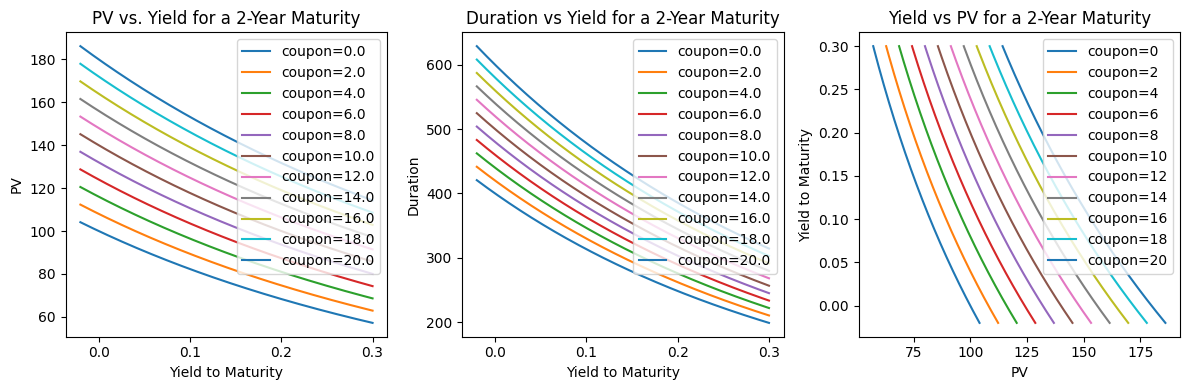

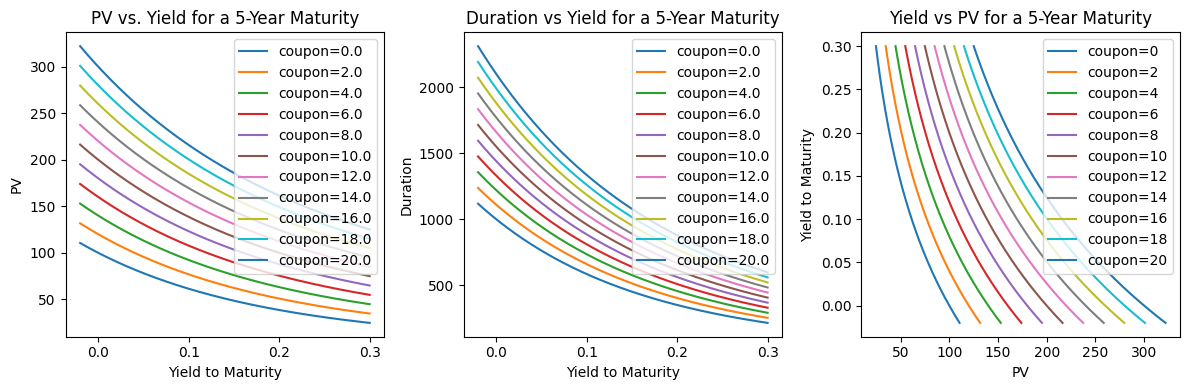

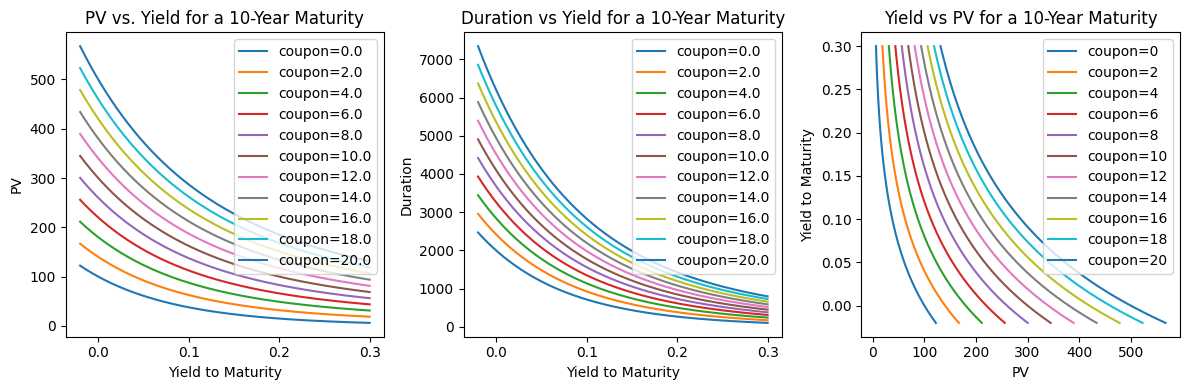

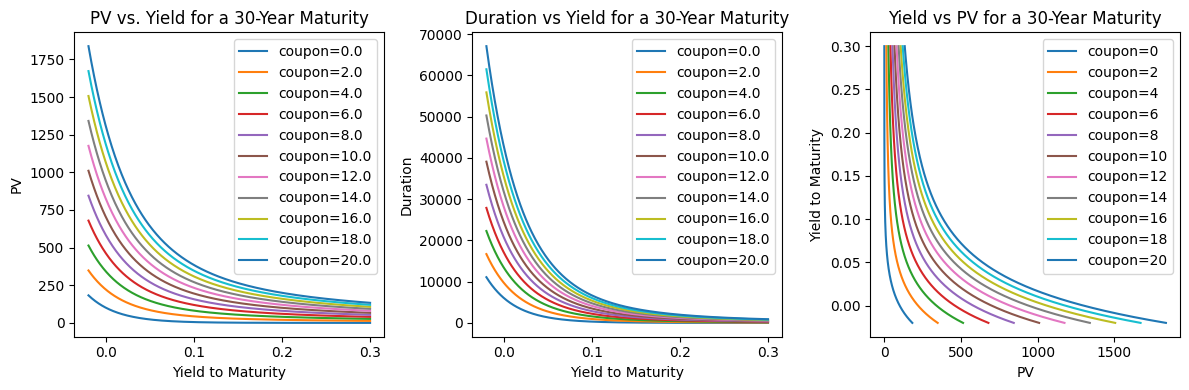

In [99]:
from scipy.optimize import newton

# Define some assumption/helper variables
ms = np.array([2, 5, 10, 30])
cs = np.arange(0, 20.5, 2) 
ys = np.linspace(-0.02, 0.30, 500)
initial_guess = 0.05
face_value=100

# Create a function to compute the PV
def compute_present_value(yield_rate, coupon, maturity_years):
    periods = maturity_years * 2
    yield_rate /= 2
    pv = coupon * (1 - (1 + yield_rate) ** -periods) / yield_rate + face_value / ((1 + yield_rate) ** periods)
    return pv

# Computes the duration
def compute_duration(yield_rate, coupon, maturity_years):
    periods = maturity_years * 2
    yield_rate /= 2
    duration = sum(k * coupon / (yield_rate + 1) ** k for k in range(1, periods + 1))
    duration += periods * face_value / (yield_rate + 1) ** periods
    return duration / (yield_rate + 1)

# Computes yield: this function uses a solving algorithm to calculate the inverse function of inferring yield from pv
def compute_yield_for_pv(target_pv, coupon, maturity_years):
    return newton(lambda yield_rate: compute_present_value(yield_rate, coupon, maturity_years) - target_pv, initial_guess)

for m in ms:
    plt.figure(figsize=(12, 4))
    # pv vs. Yield
    plt.subplot(1, 3, 1)
    for c in cs:
        pvs = [compute_present_value(y, c, m) for y in ys]
        plt.plot(ys, pvs, label=f'coupon={c}')
    plt.title(f'PV vs. Yield for a {m}-Year Maturity')
    plt.xlabel('Yield to Maturity')
    plt.ylabel('PV')
    plt.legend()
    # Duration vs. Yield
    plt.subplot(1, 3, 2)
    for c in cs:
        durations = [compute_duration(y, c, m) for y in ys]
        plt.plot(ys, durations, label=f'coupon={c}')
    plt.title(f'Duration vs Yield for a {m}-Year Maturity')
    plt.xlabel('Yield to Maturity')
    plt.ylabel('Duration')
    plt.legend()
    # Yield vs. pv
    plt.subplot(1, 3, 3)
    for c in cs:
        pvs = [compute_present_value(y, c, m) for y in [-0.02, 0.30]]
        ps = np.linspace(*pvs, 500)
        inferred_ys = [compute_yield_for_pv(p, c, m) for p in ps]
        plt.plot(ps, inferred_ys, label=f'coupon={int(c)}')
    plt.title(f'Yield vs PV for a {m}-Year Maturity')
    plt.xlabel('PV')
    plt.ylabel('Yield to Maturity')
    plt.tight_layout()
    plt.legend()
    plt.show()